# Knowledge Base Classification

## Load imports.

In [1]:
# Make common scripts visible and unsupervised classifier code
import sys
sys.path.append('../common/')
sys.path.append('../kb-classifier/')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from loader import load_preprocessed_data
from lookup_tables import topic_code_to_topic_dict, topic_code_to_int, int_to_topic_code
from kb_classifier import KnowledgeBasePredictor
from kb_common import int_to_topic

## Load the data.

In [2]:
x, y = load_preprocessed_data('data/rcv1_no_stopwords_reduced.csv')
x = np.array(x)
y = np.array(y)

# Get 20% test
total_examples = len(y)
split_point = int(total_examples * 0.8)
test_x = x[split_point:]
test_y = y[split_point:]

# Take N documents of each type from the training set for classifier tuning
train_x = []
train_y = np.zeros(shape=120)

counts = np.zeros(shape=len(topic_code_to_int.keys()))
current_index = 0
print(split_point)
for i in range(split_point):
    topic_int = y[i]
    
    if counts[topic_int] < 20:
        train_x.append(x[i])
        train_y[current_index] = topic_int
        counts[topic_int] += 1
        current_index += 1

print(counts)

2091
[20. 20. 20. 20. 20. 20.]


## Initialise and tune class probabilities for unsupervised learner

In [4]:
np.random.seed(42)
kb_predictor = KnowledgeBasePredictor(topic_code_to_topic_dict.values(), topic_depth=1)
kb_predictor.fit_tfidf(train_x)
kb_predictor.train(train_x, train_y)

Wiki topic probabilies shape: (120, 300)


In [5]:
predict_y = kb_predictor.predict(train_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(train_y, predict_y)

print(classification_report)
print(confusion_matrix)

Wiki topic probabilies shape: (120, 300)
                        precision    recall  f1-score   support

CRIME, LAW ENFORCEMENT   1.000000  1.000000  1.000000        20
  ECONOMIC PERFORMANCE   1.000000  1.000000  1.000000        20
             ELECTIONS   1.000000  1.000000  1.000000        20
                HEALTH   1.000000  1.000000  1.000000        20
              RELIGION   1.000000  1.000000  1.000000        20
                SPORTS   1.000000  1.000000  1.000000        20

             micro avg   1.000000  1.000000  1.000000       120
             macro avg   1.000000  1.000000  1.000000       120
          weighted avg   1.000000  1.000000  1.000000       120

[[20  0  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  0  0 20  0  0]
 [ 0  0  0  0 20  0]
 [ 0  0  0  0  0 20]]


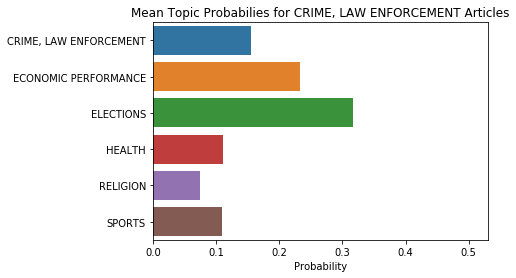

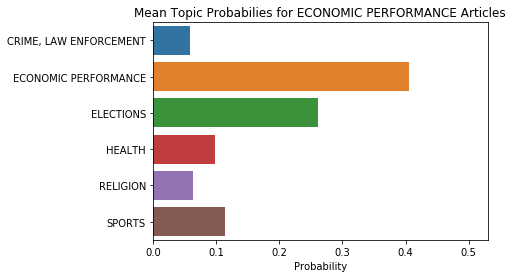

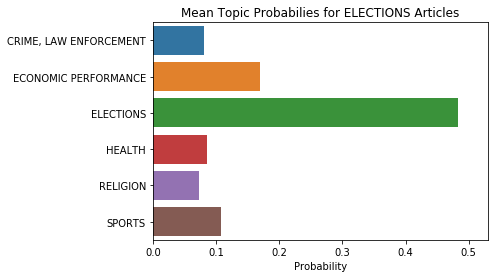

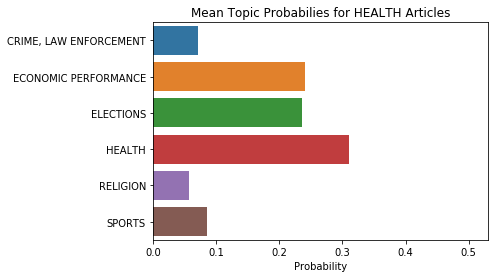

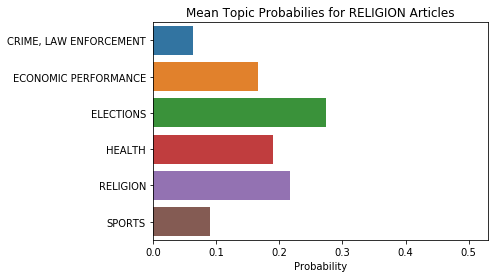

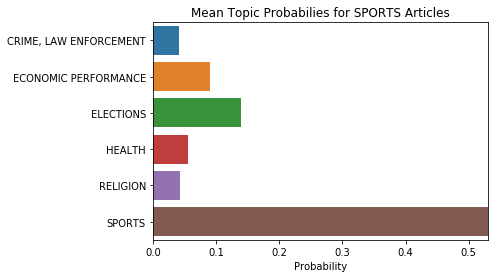

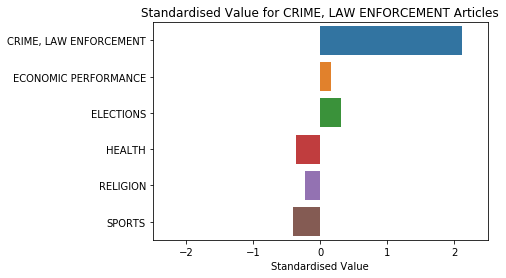

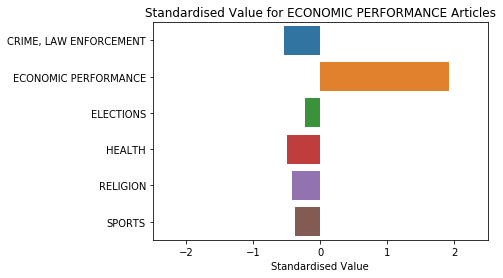

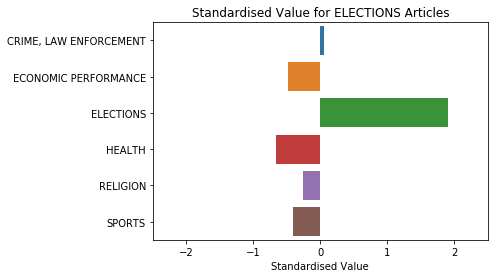

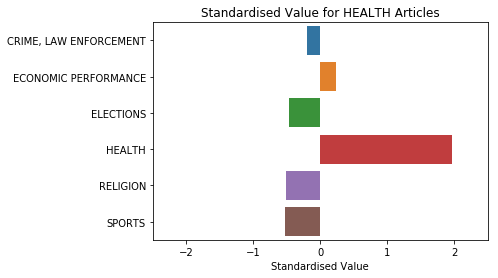

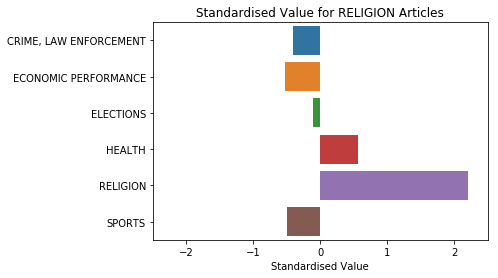

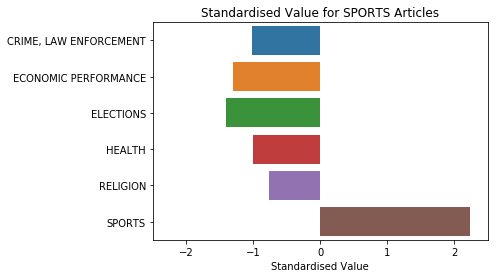

In [6]:
prob_means = np.zeros(shape=(6, 6))

# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_means[index] = prob_mean
    
    plt.figure()
    plt.title('Mean Topic Probabilies for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Probability')
    plt.xlim(0.0, 0.53)
    sns.barplot(x=prob_mean, y=list(int_to_topic.values()))
    plt.savefig('topic_prob_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()
    
# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    
    plt.figure()
    plt.title('Standardised Value for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Standardised Value')
    plt.xlim(-2.5, 2.5)
    sns.barplot(x=((prob_mean-np.mean(prob_means, axis=0))/np.std(prob_means, axis=0)),
                   y=list(int_to_topic.values()))
    plt.savefig('standardised_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()

## Assess unsupervised classifier performance.

In [7]:
print('Making predictions for {} documents'.format(len(test_y)))
predict_y = kb_predictor.predict(test_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(test_y, predict_y)

print(classification_report)
print(confusion_matrix)

Making predictions for 523 documents
Wiki topic probabilies shape: (523, 300)
                        precision    recall  f1-score   support

CRIME, LAW ENFORCEMENT   0.981132  0.816754  0.891429       191
  ECONOMIC PERFORMANCE   0.746667  0.965517  0.842105        58
             ELECTIONS   0.803279  0.890909  0.844828        55
                HEALTH   0.642857  0.750000  0.692308        36
              RELIGION   0.733333  1.000000  0.846154        11
                SPORTS   0.982456  0.976744  0.979592       172

             micro avg   0.892925  0.892925  0.892925       523
             macro avg   0.814954  0.899987  0.849402       523
          weighted avg   0.908366  0.892925  0.895394       523

[[156  10   8  12   4   1]
 [  0  56   0   0   0   2]
 [  1   5  49   0   0   0]
 [  1   4   4  27   0   0]
 [  0   0   0   0  11   0]
 [  1   0   0   3   0 168]]


## Find examples where predictions went wrong

In [13]:
for topic_code, index in topic_code_to_int.items():
    topic_subset = predict_y[test_y == index]
    topic_subset_incorrect = topic_subset[topic_subset != index]
    document_subset = test_x[test_y == index]
    document_subset = document_subset[topic_subset != index]
    
    print('------ 5 random erroneous predictions for {} ------'.format(topic_code_to_topic_dict[topic_code]))
    print('')
    random_indices = np.random.choice(np.arange(len(topic_subset_incorrect)), 5)
    for index in random_indices:
        print(document_subset[index])
        print('')
        print('Above classified as {}'.format(topic_code_to_topic_dict[int_to_topic_code[topic_subset_incorrect[index]]]))
        print('')
    print('')

------ 5 random erroneous predictions for CRIME, LAW ENFORCEMENT ------

Brazilian government suspects manipulation large banks part week rollercoaster ride Sao_Paulo bolsa percent newspapers Jornal Brasil Correio_Braziliense dailies Securities_Exchange_Commission CVM major players stock prices millions dollars futures market today many small medium size investors actions manipulators CVM head Francisco_Costa e Silva Jornal Brasil economic columnist Guilherme_Barros important small investors everything last days Costa e Silva Brazilian shares past week rising nervousness Thailand Philippines currency devaluations Economists Brazil many characterictics countries markets vulnerable speculative attacks current account trade gaps overvalued currency loose fiscal controls Brazil fundamentals solid investors currency woes Asia pretext Brazilian shares extraordinary percent beginning year Correio_Braziliense Costa e Silva several large banks millions dollars bull unhindered futures market mar

------ 5 random erroneous predictions for ELECTIONS ------

Hong_Kong stocks close pre-election jitters profit-taking local overseas institutions brokers market fall bit surprise strength morning short-term traders profits election broker large European house Hang_Seng_Index points last minutes trading points time intraday high mid-morning Turnover bullish HK HK chief worry serious imbalance U.S._Congress Kieren_Hung vice president G.K._Goh Brokers Hang_Seng_Index futures market active total contracts open interest steady contracts contract points 17-point discount cash market Brokers little talk market risk open positions Russian President_Boris_Yeltsin underwent heart surgery blue chips utilities performing commercial industrial sector sector modest gain Hongkong_Telecom HK HK company first half results percent increase net profit Brokers result line expectations China_Light HK HK healthy turnover HK percent fall profits year company sales growth remainder decade low Property stocks 

------ 5 random erroneous predictions for SPORTS ------

*** BIRTHDAYS_***_Physician_EDWARD_DAVY pioneer Victoria South_Australia electric relay copper smelter Australian politician JOHN_MCELHONE need Australia population Australian engineer WILLIAM_KERNOTT professor Melbourne_University English-born comedian STAN_LAUREL JEFFERSON successful film career United_States OLIVER_HARDY Australian aviator HENRY_'GOYER HENRY New_Guinea coastal shipping leg air crash English cricketer TOM_GRAVENEY time British sportsmen Aboriginal politician CHARLES_NELSON_PERKINS country singer BILLY CRASH CRADDOCK well-known hit Rub country *** EVENTS *** last great battle English soil end War Roses houses York Lancaster soldiers Battle Stoke English throne Tudor monarchs thousand people huge earthquake Ponnah East_Indies English explorer CHARLER_STURT Australia age Salvation Army ladies distinctive bonnets first time London year old Pepsi_Cola company trade name Pepsi-Cola first places 24-hour Le_Mans endura